In [2]:
!git clone https://github.com/nitish-nayak/dune-cvn.git

Cloning into 'dune-cvn'...
remote: Enumerating objects: 1447, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (335/335), done.
remote: Total 1447 (delta 11), reused 339 (delta 7), pack-reused 1104
Receiving objects: 100% (1447/1447), 89.34 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Checking out files: 100% (339/339), done.


In [3]:
%cd dune-cvn

/content/dune-cvn


In [4]:
%ls

dataset/                LICENSE   README.md         test_dune_cvn.ipynb
dataset_highstats/      modules/  requirements.txt  test.py
dune_cvn_nusteam.ipynb  output/   saved_model/      utils.py


The `dataset` folder contains 20 events in .gz files. Each .gz file is a compressed binary made up of three 500x500 images for the DUNE HD design, with 2 induction planes and 1 collection plane. 

There's also a `dataset_highstats` folder which we will use here that contains 100 events for each of `nueCC`, `numuCC` and `NC`, in the same .gz format

To access the truth labels for these events, we will need to read in pickle (`.p`) files. 

In [7]:
# import some useful modules
!cat utils.py
from utils import *

"""
DUNE CVN test module.
"""
__version__ = '1.0'
__author__ = 'Saul Alonso-Monsalve, Leigh Howard Whitehead'
__email__ = "saul.alonso.monsalve@cern.ch, leigh.howard.whitehead@cern.ch"

import shutil
import numpy as np
import pickle as pk
import sys
import os

sys.path.append(os.path.join(sys.path[0], 'modules'))

from tensorflow.keras.models import model_from_json
from sklearn.metrics import classification_report, confusion_matrix
from data_generator import DataGenerator
from opts import get_args
from keras.models import load_model
import my_losses
from dune_cvn import CustomTrainStep

# manually specify the GPUs to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"



In [9]:
# some useful variables for our code
test_values = []
TEST_PARAMS = {'batch_size':1, #batch size for network evaluation (model.predict)
               'images_path':'dataset_highstats', # folder where all the images lie
               'shuffle':False, # whether we want to shuffle the files (doesn't matter for us, since we're just evaluating them one by one)
               'test_values':test_values}

Here, we'll load the truth labels from the `.p` files. 

In [10]:
# load dataset into IDs, labels 
def get_labels(flav):
  print('Reading dataset from serialized file...')
  filename = TEST_PARAMS['images_path']+'/'+flav+'/partition_'+flav+'.p'
  with open(filename, 'rb') as partition_file:
      labels = pk.load(partition_file)
      IDs = list(labels.keys())
  print('Loaded. Number of test examples for flavor %s : %d'%(flav,len(IDs)))
  return IDs, labels

In [11]:
IDs, labels = get_labels('nue') # load pickle file for nueCC events

Reading dataset from serialized file...
Loaded. Number of test examples for flavor nue : 100


In [12]:
print(IDs) # list of strings (strings involve characters inside single quotes or double quotes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [13]:
print(labels) # dictionary which is an "array" of key, value pairs. we need this as a look-up table. 

{'0': [0, 1, 2, 0, 0, 1, 3], '1': [0, 1, 3, 1, 0, 0, 1], '2': [0, 1, 2, 3, 1, 0, 3], '3': [1, 1, 2, 0, 1, 1, 1], '4': [0, 1, 2, 0, 1, 0, 1], '5': [0, 1, 0, 1, 0, 0, 1], '6': [0, 1, 2, 2, 0, 1, 2], '7': [0, 1, 2, 1, 1, 0, 1], '8': [0, 1, 1, 3, 0, 0, 3], '9': [0, 1, 1, 1, 1, 0, 0], '10': [0, 1, 2, 3, 0, 0, 0], '11': [0, 1, 1, 1, 0, 0, 1], '12': [0, 1, 0, 1, 0, 0, 0], '13': [0, 1, 3, 2, 0, 0, 0], '14': [0, 1, 2, 0, 3, 0, 2], '15': [0, 1, 2, 1, 1, 3, 0], '16': [0, 1, 2, 1, 3, 1, 3], '17': [0, 1, 2, 0, 1, 0, 3], '18': [0, 1, 2, 1, 2, 0, 0], '19': [0, 1, 0, 1, 0, 0, 0], '20': [0, 1, 1, 1, 0, 1, 1], '21': [0, 1, 2, 0, 0, 0, 1], '22': [0, 1, 2, 1, 3, 2, 2], '23': [0, 1, 1, 1, 1, 0, 0], '24': [0, 1, 0, 2, 0, 0, 0], '25': [0, 1, 3, 1, 0, 0, 3], '26': [0, 1, 1, 2, 0, 0, 1], '27': [0, 1, 1, 3, 0, 0, 3], '28': [0, 1, 2, 2, 3, 0, 2], '29': [0, 1, 2, 1, 1, 0, 0], '30': [0, 1, 1, 3, 0, 0, 3], '31': [0, 1, 3, 2, 0, 0, 0], '32': [0, 1, 3, 2, 0, 0, 0], '33': [0, 1, 0, 1, 0, 0, 1], '34': [0, 1, 2, 2, 2, 0

In [14]:
# lookup value for key = '1'
print(labels['1'])

[0, 1, 3, 1, 0, 0, 1]


`labels` is a dictionary that contains the truth information for each event indexed by keys `'0' - '99'`. Remember the CNN has been trained to predict a bunch of information about the topology and not just the flavor. We will only focus on the flavor tagging aspect for now, which is given by the second element of the list

In [19]:
print(labels['1'][1])

1


The second element is enumerated as: 


*   0 - numuCC
*   1 - nueCC
*   2 - nutauCC
*   3 - NC





In [20]:
import zlib
# this function reads the .gz image file given an argument like '0' or '1' or '2' and so on
def get_pixelmap(key, flav): # with a default value
    path = TEST_PARAMS['images_path']+'/'+flav
    with open(path+'/event'+key+'.gz', 'rb') as image_file:
        pixels = np.fromstring(zlib.decompress(image_file.read()), dtype=np.uint8, sep='').reshape(3, 500, 500)
        return pixels

In [21]:
get_pixelmap('0', 'nue')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

This is a `3x500x500` array of integers. Each pixel represents the energy deposited, but digitized into a 16-bit integer. Lets try to plot them to see how it looks

In [22]:
import matplotlib.pylab as plt

# useful variable which we use in the code later on
flav_keys=['numucc', 'nuecc', 'nutaucc', 'NC']
# function meant to draw an image. Input here is the image that we obtain from the previous function get_pixelmap
def draw_single_pm(pm):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.suptitle('Pixel Maps')        
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = np.swapaxes(pm[i], 0, 1)
        axs[i].imshow(maps, interpolation='none', cmap='cool')
        axs[i].set_xlabel('Wire')
        axs[i].set_ylabel('TDC')
        axs[i].title.set_text(titles[i])
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


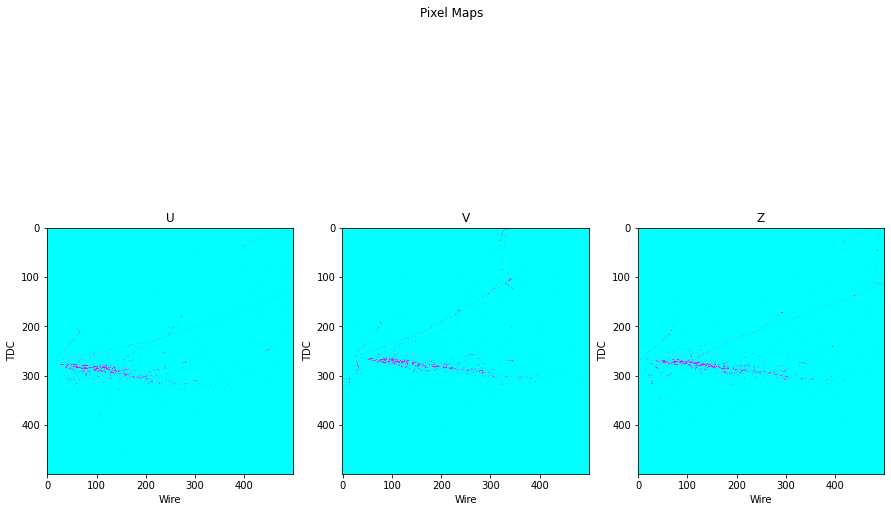

In [23]:
pm = get_pixelmap('15', 'nue')
draw_single_pm(pm)

Here, the x-axis is the `Wire` number associated with that anode-plane. `U` and `V` denoting the induction planes and `Z` denoting the collection. TDC refers to the time tick which is related to the time it takes for the drift electrons to travel to the anode plane from the ionization point. 

Now let's try to evaluate our trained network on these images. For that we have to first re-jig the pixel array we got from the `.gz` file into a numpy array format that the network expects. 

In [25]:
# convert image from .gz file (3 images, 500x500 pixels) to some format that the neural network understands
def convert_pm(pm):
    views = len(pm)
    planes = pm.shape[1]
    cells = pm.shape[2]
    
    X = [None]*views
    for view in range(views):
        X[view] = np.zeros((1, planes, cells, 1), dtype='float32')
    for view in range(views):
        X[view][0, :, :, :] = pm[view, :, :].reshape(planes, cells, 1)
    return X

In [29]:
# loads the already trained neural network model for evaluation
def get_model(print_model=False): 
    with open('saved_model/model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights('saved_model/weights.h5')

    if(print_model):
        model.summary()
    return model
model = get_model() # get the neural network model

Let's try to print the results of the network evaluation along with the plot above for a nice summary on what's happening for each event. 

The following code also allows us to manipulate images in ways like : 


*   Flipping - flip the images horizontally and then evaluate the network
*   TurnOff - Turning off one image out of the 3 and see how the network responds to having lesser information. 

But for now, we won't have to worry about this. 



In [30]:
# print results of network evaluation on input image
def print_pminfo(pm, ID):
    print('Results of network evaluation on pixel map')
    scores = model.predict(convert_pm(pm))
    flav_score = np.max(scores[1], axis=1)
    flav_pred = np.argmax(scores[1], axis=1)
    print('CVN score for pred label : %f, True Label : %s, Pred Label : %s'%
      (flav_score[0], flav_keys[labels[ID][1]], flav_keys[flav_pred[0]]))
    print('CVN score for true label : ', scores[1][0][labels[ID][1]])
    print('All scores :', scores[1])

# draw image and also print results of network evaluation
# flip = True, False (to flip each image horizontally)
# turnoff = 0, 1 or 2 (to turn off particular images before evaluation)
def show_pminfo(key, flav, flip=False, turnoff=None):
    
    pm = get_pixelmap(key, flav)
    print('shape of image : ', pm.shape)
    print('Drawing pixel map')
    pm2 = pm
    if flip:
        #pm2 = np.empty(pm.shape, dtype=np.uint8)
        # flips the image
        for view in range(3):
            pm2[view] = np.flip(pm[view], axis=1)
            
    if turnoff is not None:
        assert (turnoff < 3 and turnoff >= 0), "turnoff can only be 0, 1 or 2"
        pm2[turnoff] = np.zeros(pm[turnoff].shape, dtype=np.uint8)

    draw_single_pm(pm2)
    print_pminfo(pm2, key)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


shape of image :  (3, 500, 500)
Drawing pixel map


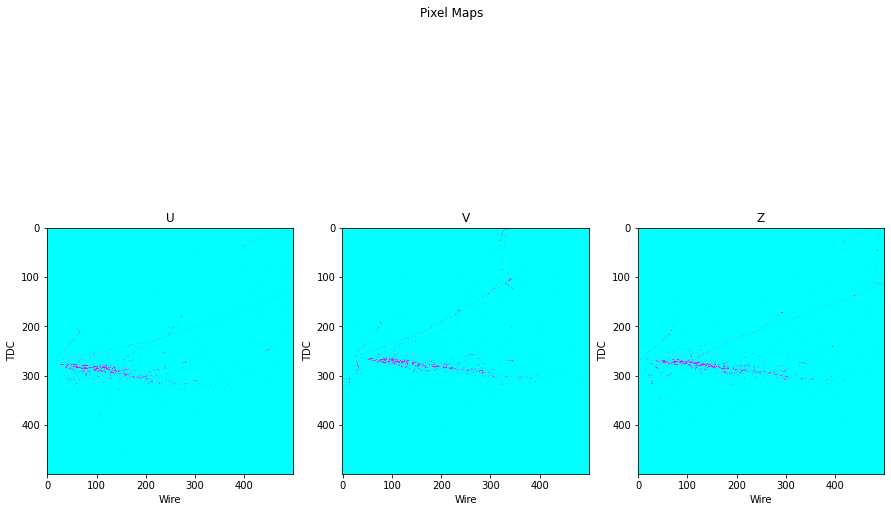

Results of network evaluation on pixel map
CVN score for pred label : 0.805564, True Label : nuecc, Pred Label : nuecc
CVN score for true label :  0.8055639
All scores : [[0.02204059 0.8055639  0.13596834 0.0364271 ]]


In [31]:
show_pminfo('15', 'nue')

Here we have: 


*   The predicted label and the true label along with the "likelihood" score the network gives for its prediction
*   In cases where the network gets it wrong, its also useful to see what the score was for the true label
*   Finally, a list of all scores for each of the 4 labels

I encourage you to play around with the inputs and see what kind of results you get and try to get a feel for whether the network is behaving accurately and as intended and where its getting confused if at all. But we'll move on to evaluate the network performance more quantitatively. 





In [32]:
# function to get the predicted label for input event
def get_pred(key, flav_event):
    pm = get_pixelmap(key, flav_event)
    scores = model.predict(convert_pm(pm))
    flav_pred = np.argmax(scores[1], axis=1)[0]

    return flav_pred

# function to get the given label score for each event. 
# For eg, one can ask it to provide the nueCC score for an NC event and so on
def get_flav_score(key, flav, flav_event):
    tags = np.array(['numu', 'nue', 'nutau', 'nc'])
    pm = get_pixelmap(key, flav_event)
    scores = model.predict(convert_pm(pm))
    flav_score = scores[1][0][np.where(tags == flav)[0][0]]

    return flav_score

Typically, the first set of numbers we look at in the test dataset are so-called confusion matrices. Essentially a matrix of `True Label` vs `Predicted Label` that tells us where the network gets things wrong and predominantly which label is the most confusing. Here we will ignore `nuTauCC` and just concentrate on `nueCC`, `numuCC` and `NC`

In [33]:
confusion_mat = np.zeros((3,3), dtype=np.uint8)
tags = ['numu', 'nue', 'nc']
for f in range(3):
  for i in range(100):
    flav_pred = get_pred(str(i), tags[f])
    if(flav_pred == 2) : continue
    if(flav_pred == 3) : flav_pred = 2
    confusion_mat[f][flav_pred] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


Here, rows are given by True Label, columns by Predicted Label. So one reads this off as, for `100` true numuCC events, the network is able to predict `95` of them accurately. `1` out of `100` is predicted as `nueCC` and `4` as NC. Similarly, one can read off for the other rows as well. 

In [34]:
print(confusion_mat)

[[95  1  4]
 [ 0 98  2]
 [ 3  4 90]]


We can normalize them by row to get an "efficiency" matrix. Also referred to as "Sensitivity" in other fields. Essentially, for given true label, we ask what fraction is predicted as signal or other background channels. 

In [35]:
eff_mat = confusion_mat/confusion_mat.sum(axis=1,keepdims=True)
print(eff_mat)

[[0.95       0.01       0.04      ]
 [0.         0.98       0.02      ]
 [0.03092784 0.04123711 0.92783505]]


The other side of this is a "purity" matrix. Or "Specificity". Essentially, for a given predicted label, we ask what fraction is actually signal or other background. Sometimes a network can get very good efficiency by predicting a particular label all the time, but that's not a good thing and this metric is designed to catch that. So for eg, we see that the network is able to predict `98%` of `nueCC` accurately and also `95%` of events that it predicts as `nueCC` are actually `nueCC`. 

In [36]:
pur_mat = confusion_mat/confusion_mat.sum(axis=0,keepdims=True)
print(pur_mat)

[[0.96938776 0.00970874 0.04166667]
 [0.         0.95145631 0.02083333]
 [0.03061224 0.03883495 0.9375    ]]


We can visualize these numbers better in the following plots. Highly diagonal matrices are a sign that the network is able to generalize to a test dataset (made up of events that it has never seen) pretty well. 

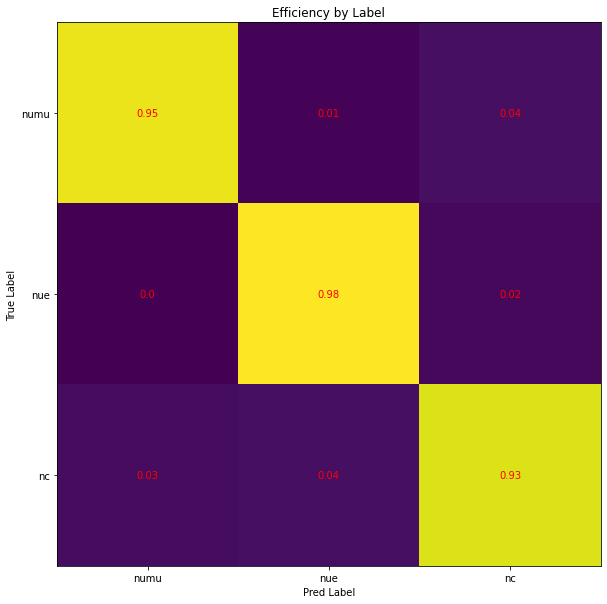

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(eff_mat, interpolation=None)

ax.set_xticks(np.arange(len(tags)))
ax.set_xticklabels(tags)
ax.set_ylabel('True Label')
ax.set_xlabel('Pred Label')
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags)
for i in range(len(tags)):
  for j in range(len(tags)):
    text = ax.text(j, i, round(eff_mat[i, j], 2), ha='center', va='center', color='r')

plt.title('Efficiency by Label')
plt.show()

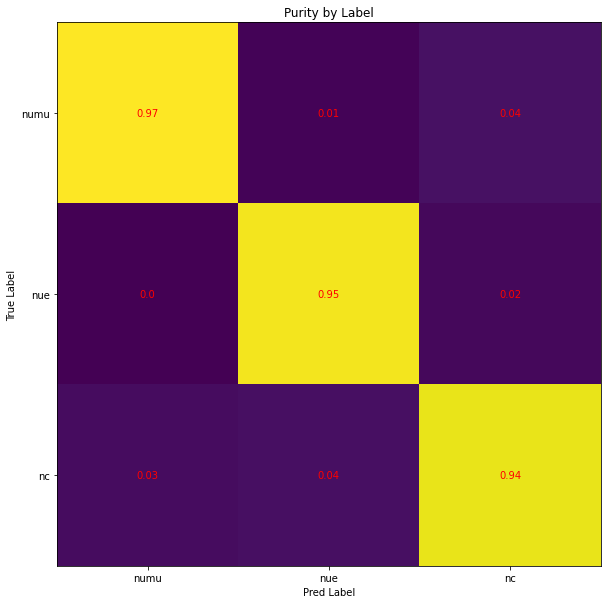

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(pur_mat, interpolation=None)

ax.set_xticks(np.arange(len(tags)))
ax.set_xticklabels(tags)
ax.set_ylabel('True Label')
ax.set_xlabel('Pred Label')
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags)
for i in range(len(tags)):
  for j in range(len(tags)):
    text = ax.text(j, i, round(pur_mat[i, j], 2), ha='center', va='center', color='r')

plt.title('Purity by Label')
plt.show()

Let's try to plot some histograms of the network scores to see how much its able to separate signal and background. Here we will look at only `nueCC` scores but as homework, one can make similar plots for `numuCC` and `NC` scores as well. 

In [39]:
# loop over events and append nueCC scores based on whether its signal or background
sig_scores = []
numu_scores = []
nc_scores = []
tags = ['numu', 'nue', 'nc']
for f in range(3):
  for i in range(100):
    flav_score = get_flav_score(str(i), 'nue', tags[f])
    if(f == 1): sig_scores.append(flav_score)
    if(f == 0): numu_scores.append(flav_score)
    if(f == 2): nc_scores.append(flav_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


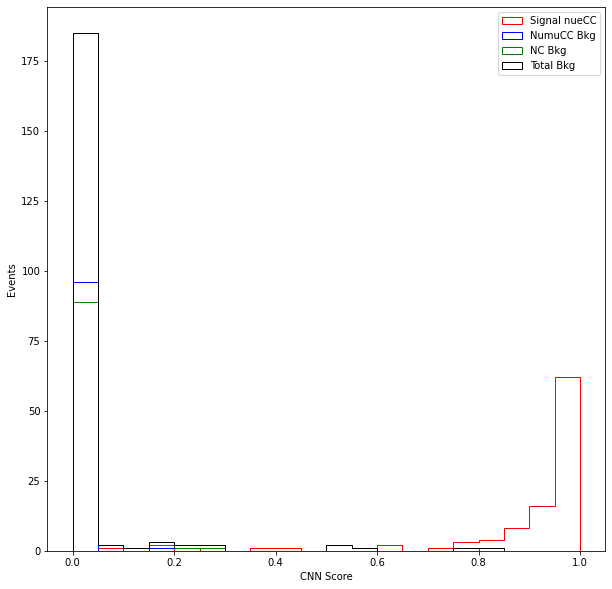

In [40]:
# make the plot
b = np.arange(0, 1.05, 0.05)
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(np.array(sig_scores), bins=b, histtype='step',color='red',linestyle='solid',label='Signal nueCC')
ax.hist(np.array(numu_scores), bins=b, histtype='step',color='blue',linestyle='solid',label='NumuCC Bkg')
ax.hist(np.array(nc_scores), bins=b, histtype='step',color='green',linestyle='solid',label='NC Bkg')
ax.hist(np.array(nc_scores+numu_scores), bins=b, histtype='step',color='black',linestyle='solid',label='Total Bkg')
ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel('CNN Score')
plt.show()

This shows that in terms of the `nueCC` scores, the true `nueCC` events peak near 1 while the background peaks near 0. This shows that the network is behaving appropriately and is able to distinguish signal and background. The better the separation in this plot, the better the performance. 

We can even try to quantify the separation using a "ROC" Curve. 


*   ROC - Receiver Operating Characteristic 

Essentially, it scans across the CNN scores and at each point gathers the fraction of background selected and the fraction of signal selected. Then, it just plots them together. It's instructive to compare this to an extremely dumb classifier which just predicts everything as nueCC without any skill, no matter which event is thrown at it. 




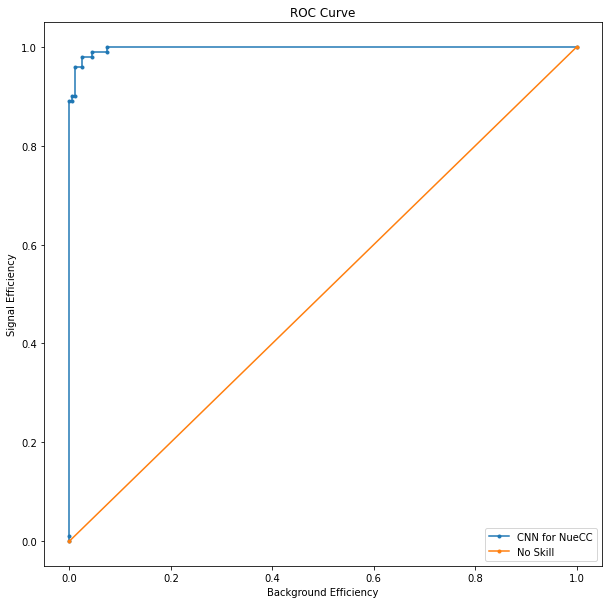

AUC scores for (CNN, No Skill) : 0.998, 0.500


In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

lr_fpr, lr_tpr, _ = roc_curve(200*[0] + 100*[1], numu_scores+nc_scores+sig_scores)
ns_fpr, ns_tpr, _ = roc_curve(200*[0] + 100*[1], 300*[1])
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lr_fpr, lr_tpr, marker='.', label='CNN for NueCC')
ax.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
ax.legend(loc='best')
ax.set_title('ROC Curve')
ax.set_xlabel('Background Efficiency')
ax.set_ylabel('Signal Efficiency')
plt.show()
lr_auc = roc_auc_score(200*[0] + 100*[1], numu_scores+nc_scores+sig_scores)
ns_auc = roc_auc_score(200*[0] + 100*[1], 300*[1])
print('AUC scores for (CNN, No Skill) : %0.03f, %0.03f'%(lr_auc, ns_auc))

One can clearly see that the CNN is obviously far superior to the "No Skill" network that just predicts `nueCC` all the time. The way to quantify this better is to estimate the "Area under the Curve" (AUC) which is one of many possible metrics. The "No Skill" one has an AUC of 0.5 while a CNN has an AUC of 0.998. 

A perfect network will have an AUC of exactly 1, so we can see our CNN is actually very very good! (Of course, there's some influence here of limited statistics, but point still stands.)

One can develop a different network and also compare with this CNN and the No Skill network to see how it performs. The AUC is one metric that can tell us which network is better.